In [1]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image
from PIL import ImageFilter
import ast
import json
from glob import glob

backbone = keras.applications.ResNet50(include_top=False, input_shape=[64, 64, 3])
#["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]]
backbone.summary()

backbone = keras.applications.ResNet50V2(include_top=False, input_shape=[64, 64, 3])
backbone.summary()

#backbone = keras.applications.ResNet50(include_top=False, input_shape=[None, None, 3])
backbone = keras.applications.EfficientNetB0(include_top=False, input_shape=[64, 64, 3])
#["block3b_add", "block4c_add", "block6d_add"]]
backbone.summary()

backbone = keras.applications.EfficientNetB0(include_top=False, input_shape=[64, 64, 3])
c3_output, c4_output, c5_output = [
    backbone.get_layer(layer_name).output
    for layer_name in ["block3b_add", "block4c_add", "block6d_add"]]

c3_output, c4_output, c5_output = [
    backbone.get_layer(layer_name).output
    for layer_name in ["block3b_add", "block4c_add", "block6d_add"]]
    #for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]]
model =  keras.Model(inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]    )

In [2]:
tf.__version__, tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.3.1', True)

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #CPU

In [264]:
padded_image_shape = (1024, 1920)
anchor_k = 9
num_classes = 80#
num_classes_real = 5
max_data_m = 50#00
use_zoom_up_data = False
level_start = 5
level_end = 8
l1 = 1e-9
activation = 'swish'#'selu' is not converted to tflite
kernel_init = tf.initializers.he_normal()
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)
class_names = ['bg', 'pig', 'crow']
folder_image = folder_pig = '/home/mvlab/Downloads/dataset/pig/object 6/'
path_csv = folder_pig + 'pig_6.csv'
path_weight = "retinanet/pig_efficient_det_BiFPN_D2"
os.path.isdir(folder_pig), os.path.isfile(path_csv)

(True, True)

In [10]:
df = pd.read_csv(path_csv)
df.shape, path_csv

((9, 7), '/home/mvlab/Downloads/dataset/pig/object 6/pig_6.csv')

In [11]:
df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,geomex-pig06_2020-09-05_164414_temp-00.00_wat-...,409923,{},4,0,"{""name"":""rect"",""x"":439,""y"":393,""width"":87,""hei...","{""class"":""crow""}"
1,geomex-pig06_2020-09-05_164414_temp-00.00_wat-...,409923,{},4,1,"{""name"":""rect"",""x"":200,""y"":596,""width"":136,""he...","{""class"":""crow""}"
2,geomex-pig06_2020-09-05_164414_temp-00.00_wat-...,409923,{},4,2,"{""name"":""rect"",""x"":223,""y"":435,""width"":550,""he...","{""class"":""pig""}"
3,geomex-pig06_2020-09-05_164414_temp-00.00_wat-...,409923,{},4,3,"{""name"":""rect"",""x"":715,""y"":251,""width"":715,""he...","{""class"":""pig""}"
4,geomex-pig06_2020-09-05_164618_temp-00.00_wat-...,409207,{},0,0,{},{}


In [13]:
df['filename'].nunique()

6

In [16]:
class_names.index('pig')

1

In [22]:
annotation = dict()
object_width_list = []
for i in range(len(df)):
    
    sample_row = df.iloc[i]
    filename = sample_row['filename']    
    region_id = sample_row['region_id']
    box = sample_row['region_shape_attributes']    
    region_attributes = sample_row['region_attributes']    
    box_map = ast.literal_eval(box)    
    region_attributes = ast.literal_eval(region_attributes)        
    
    if len(box_map.keys())<1:
        print(i, 'no_keys_skip', filename)
        continue
        
    cls = region_attributes['class']                
    cls_num = class_names.index(cls)
    x0 = box_map['x']
    y0 = box_map['y']
    width = box_map['width']
    height = box_map['height']    
    x1 = x0 + width
    y1 = y0 + height
    object_width_list.append(width)
    if True:
        margin = 0
        #print('margin', width, margin)
        x0 -= margin
        y0 -= margin
        x1 += margin
        y1 += margin
    
    bbox = [cls_num, x0, y0, x1, y1]
    
    if filename not in annotation.keys():
        annotation[filename] = []
    
    annotation[filename].append(bbox)
        
    #print(i, df.loc[i, 'filename'], width, height)

4 no_keys_skip geomex-pig06_2020-09-05_164618_temp-00.00_wat-00.00.jpg
5 no_keys_skip geomex-pig06_2020-09-05_164822_temp-00.00_wat-00.00.jpg
6 no_keys_skip geomex-pig06_2020-09-05_165026_temp-00.00_wat-00.00.jpg
7 no_keys_skip geomex-pig06_2020-09-05_165230_temp-00.00_wat-00.00.jpg
8 no_keys_skip geomex-pig06_2020-09-05_165435_temp-00.00_wat-00.00.jpg


In [23]:
annotation

{'geomex-pig06_2020-09-05_164414_temp-00.00_wat-00.00.jpg': [[2,
   439,
   393,
   526,
   506],
  [2, 200, 596, 336, 679],
  [1, 223, 435, 773, 739],
  [1, 715, 251, 1430, 697]]}

In [56]:
np.min(object_width_list), np.mean(object_width_list), np.max(object_width_list)

(87, 372.0, 715)

(array([2., 0., 0., 0., 0., 0., 0., 1., 0., 1.]),
 array([ 87. , 149.8, 212.6, 275.4, 338.2, 401. , 463.8, 526.6, 589.4,
        652.2, 715. ]),
 <a list of 10 Patch objects>)

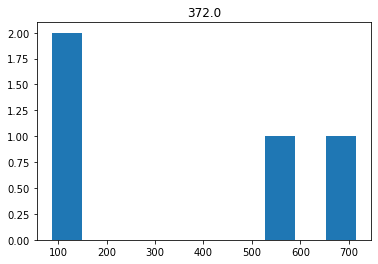

In [24]:
plt.title(str(np.mean(object_width_list)))
plt.hist(object_width_list)

In [27]:
folder_image

'/home/mvlab/Downloads/dataset/pig/object 6/'

In [29]:
input_list = []
bbox_list = []
path_list = []
for key in annotation:
    cls_bbox = annotation[key]
    cls_bbox = np.array(cls_bbox).reshape([-1, 5])
    cls = cls_bbox[:, 0:1]
    bbox = np.array(cls_bbox[:, 1:])
        
    path_image = folder_image + key
    if os.path.isfile(path_image):
        img = Image.open(path_image)    
        scale = np.array((img.width, img.height, img.width, img.height))
        scale = np.reshape(scale, (1, 4))       
        #print(key, cls, cls_bbox.dtype, cls_bbox, 'wh',img.width, img.height)
        img_arr = np.array(img)        
        bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
        cls_bbox_norm = np.concatenate((cls, bbox_norm), axis=1)

        input_list.append(img_arr)
        bbox_list.append(cls_bbox_norm)
        path_list.append(key)
        if len(input_list)%100==0:        
            print(len(annotation), len(input_list), len(bbox_list))   
    else:
        print('not exist', path_image)

print(len(input_list), len(bbox_list))

1 1


(4, 5)


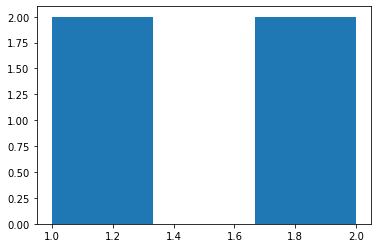

In [30]:
cbbox = np.concatenate(bbox_list, 0)
print(cbbox.shape)
h = plt.hist(cbbox[:, 0], bins=len(class_names))

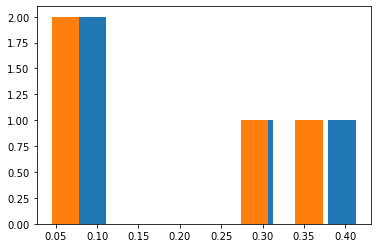

In [31]:
box_w = cbbox[:, -2] - cbbox[:, -4]
box_h = cbbox[:, -1] - cbbox[:, -3]
h = plt.hist(box_h)
h = plt.hist(box_w)

In [32]:
 np.corrcoef(box_w, box_h)

array([[1.        , 0.98260098],
       [0.98260098, 1.        ]])

In [33]:
box_y = cbbox[:, -1]
box_x = cbbox[:, -2]
box_size = np.sqrt(box_w * box_h)
np.corrcoef(box_y, box_x), np.corrcoef(box_x, box_h), np.corrcoef(box_y, box_h)

(array([[1.       , 0.3668958],
        [0.3668958, 1.       ]]),
 array([[1.        , 0.96321359],
        [0.96321359, 1.        ]]),
 array([[1.        , 0.55584118],
        [0.55584118, 1.        ]]))

In [34]:
np.correlate(box_x, box_h), np.corrcoef(box_x, box_h)[1, 0]

(array([0.46301022]), 0.963213590509265)

In [35]:
np.corrcoef(box_x, box_size)[1, 0], np.corrcoef(box_y, box_size)[1, 0]

(0.9324336952250627, 0.6411897143717594)

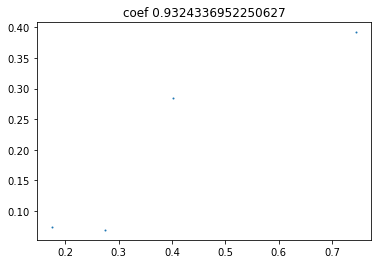

In [36]:
plt.title('coef '+ str(np.corrcoef(box_x, box_size)[1, 0]))
plt.scatter(box_x, box_size, s=1)

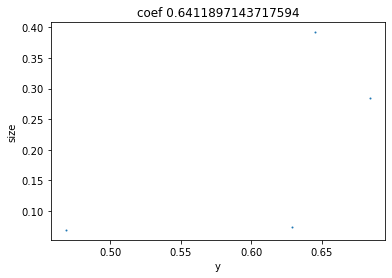

In [37]:
plt.title('coef '+ str(np.corrcoef(box_y, box_size)[1, 0]))
plt.xlabel('y')
plt.ylabel('size')
plt.scatter(box_y, box_size, s=1)

In [38]:
cbbox.shape

(4, 5)

In [39]:
def crop_bbox_image(image, boxes):
    img_objects = []
    image = np.array(image)
    for box in boxes:        
        box = box.astype(np.int)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1        
        crop_image_arr = image[y1:y2, x1:x2]
        ch, cw, cc = crop_image_arr.shape
        if ch>1 and cw>1:
            img_objects.append(crop_image_arr)
        else:
            print('crop_bbox_image', x2-x1, y2-y1, 'crop_image_arr.shape', crop_image_arr.shape)
        
    return img_objects
    
    
def attach_crop_image(image, boxes, max_crop=200):
        
    crop_bbox_arr = crop_bbox_image(image, np.array(boxes)[:max_crop])
    bbox_k = len(crop_bbox_arr)
    max_col = 30
    
    if bbox_k > 0:
        img_h, img_w, img_c = image.shape
        object_img_w = img_w//bbox_k        
        resize_h = img_h // 8
        resize_w = img_w // bbox_k  
        resize_w = min(max(resize_w, img_w//max_col), img_w//8)
        
        footer_h = resize_h * (1 + (bbox_k-1)//max_col)
        footer = np.zeros((footer_h, img_w, img_c), np.uint8)
        
        for i in range(min(bbox_k, max_crop)):
            crop_arr = crop_bbox_arr[i]
            crop_img = Image.fromarray(crop_arr)                
            crop_img = crop_img.resize((resize_w, resize_h))
            crop_arr_resized = np.array(crop_img)
            offset_y = (i//max_col) * resize_h
            offset_x = (i%max_col) * resize_w
            footer[offset_y:offset_y+resize_h, offset_x:offset_x+resize_w] = crop_arr_resized

        seperate_line = np.zeros_like(footer[:2])
        image = np.concatenate((image, seperate_line, footer), axis=0)    
    return image    

In [40]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        color = edgecolors[int(cls)]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 70:
            score_txt = class_names[int(cls)]
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [41]:
def tile_object(X, BBOX, scope=0.5):
    
    crop_xs = []
    crop_bboxs = []
    for i in range(len(X)):
        x = X[i]
        img_h, img_w, img_c = x.shape
        bbox = BBOX[i]
        #print('len', len(x), len(bbox), x.shape, bbox.shape)
        cls = bbox[:, 0]
        x0 = bbox[:, 1]
        y0 = bbox[:, 2]
        x1 = bbox[:, 3]
        y1 = bbox[:, 4]
        box_h = y1 - y0
        box_w = x1 - x0
        box_y_min = np.min(y0)
        box_x_min = np.min(x0)        
        box_y_max = np.max(y1)
        box_x_max = np.max(x1)        
        if box_y_max - box_y_min < scope and box_x_max - box_x_min < scope:
            
            cx = np.mean((box_x_min + box_x_max)/2)
            
            if cx < 0.5:
                tx0 = np.maximum(0, cx - scope/2)
                tx1 = tx0 + scope
            else:
                tx1 = np.minimum(1.0, cx + scope/2)
                tx0 = tx1 - scope
                        
            tbox = np.stack((cls, (x0 - tx0)/scope, y0, (x1 - tx0)/scope, y1), axis=1)
            
            
            img_x0 = int(tx0 * img_w)
            img_x1 = img_x0 + int(img_w*scope)
            timg = x[:, img_x0:img_x1]
            
            img = Image.fromarray(timg)
            img_resized = img.resize((padded_image_shape[1]//2, padded_image_shape[0]))
            arr_resized = np.array(img_resized)            
            
            crop_xs.append(arr_resized)
            crop_bboxs.append(tbox)
    return crop_xs, crop_bboxs


In [42]:
def attach_tiled_data(X, BBOX, row=2, col=2):
    m = len(X)
    attach_m = int(np.ceil(m/(row*col)))
    attach_xs = []
    attach_bboxs = []
    img_h, img_w, img_c = X[0].shape
    for i in range(attach_m):
        bg_color = np.median(X[i])
        attach_xs.append(bg_color + np.zeros((img_h*row, img_w*col, img_c)))    
        attach_bboxs.append([])
    
    m_rand = np.arange(m)
    np.random.shuffle(m_rand)
    for i in range(len(m_rand)):
        j = i#m_rand[i]
        x = X[j]
        bbox = BBOX[j]        
        img_h, img_w, img_c = x.shape
        ti = i//(row*col)
        ty = i%(row*col)//col
        tx = i%(row*col)%col
        dst_y0 = ty * img_h
        dst_y1 = dst_y0 + img_h
        dst_x0 = tx * img_w
        dst_x1 = dst_x0 + img_w
               
        attach_xs[ti][dst_y0:dst_y1, dst_x0:dst_x1] = x                    
        cls, x0, y0, x1, y1 = np.split(bbox, 5, -1)
        
        x_scale = 1.0 / col
        y_scale = 1.0 / row
        x0 = x0 * x_scale + tx * x_scale
        y0 = y0 * y_scale + ty * y_scale
        x1 = x1 * x_scale + tx * x_scale
        y1 = y1 * y_scale + ty * y_scale
        bbox = np.concatenate((cls, x0, y0, x1, y1), axis=1)        
        attach_bboxs[ti].extend(bbox)
            
    for i in range(len(attach_bboxs)):
        attach_bboxs[i] = np.stack(attach_bboxs[i], 0)
        
    return attach_xs, attach_bboxs

In [43]:
def box_convert_cxy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate(( (y0+y1)/2, (x0+x1)/2 ), axis=1)

def box_swap_xy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate((x0, y0, x1, y1), axis=1)

def box_convert_to_xywh(boxes):
    return np.concatenate(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]], axis=-1,)

def box_convert_to_corners(boxes):    
    return np.concatenate(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1,)

def angle_to_radian(angle):
    return angle * np.pi/180

def rotate_images(X, angle):
    rotate_X = []
    for i in range(len(X)):        
        x = X[i]
        img_h = x.shape[0]
        img_w = x.shape[1]
        img = Image.fromarray(x)                
        img_rotated = img.rotate(angle)
        rotate_X.append(np.array(img_rotated))

    return rotate_X
    
def gen_rotate_data(X, BBOX, angle):
    rotate_xs = []
    rotate_bboxs = []
    m = len(X)
    for i in range(m):        
        x = X[i]
        
        bbox = BBOX[i]
        cls = bbox[:, 0]
        x0 = bbox[:, 1]
        y0 = bbox[:, 2]
        x1 = bbox[:, 3]
        y1 = bbox[:, 4]
        
        box = bbox[:, 1:]
        box_xywh = box_convert_to_xywh(box)
        box_xy = box_xywh[:, :2] 
        box_wh = box_xywh[:, 2:] 
        box_uv = (np.reshape(box_xy, [-1, 2]) - 0.5) * 2
        
        img_h, img_w, img_c = x.shape
        img = Image.fromarray(x)        
        scale_mat = np.array([1, 0, 0, 1.0*img_h/img_w]).reshape((2,2))
        scale_mat_rev = np.array([1, 0, 0, 1.0*img_w/img_h]).reshape((2,2))
        
        angle = angle + np.random.normal(scale=np.abs(angle))
        radian = angle_to_radian(angle)        
        rotate_mat = np.array([np.cos(radian), -np.sin(radian), np.sin(radian), np.cos(radian)])        
        rotate_mat = np.reshape(rotate_mat, (2, 2))
        box_uv_trans = np.matmul(box_uv, scale_mat)
        box_uv_trans = np.matmul(box_uv_trans, rotate_mat)
        box_uv_trans = np.matmul(box_uv_trans, scale_mat_rev)
        box_trans = (box_uv_trans + 1)/2
        box_trans_xy = np.reshape(box_trans, [-1, 2])
        box_trans_xywh = np.concatenate((box_trans_xy, box_wh), axis=1)
        box_trans = box_convert_to_corners(box_trans_xywh)
   
        #if np.min(box_trans)<0 or np.max(box_trans)>1: continue
        
        bbox_trans = np.concatenate((np.expand_dims(cls, 1), box_trans), axis=1)
   
        img_rotated = img.rotate(angle)
        #plt.imshow(img_rotated)
        rotate_xs.append(np.array(img_rotated))
        rotate_bboxs.append(bbox_trans)

    return rotate_xs, rotate_bboxs        

In [44]:
def crop_obj(X, Y):
    crop_obj_list = []
    shape_list = []
    cls_list = []
    for i in range(len(X)):        
        x = X[i]        
        bboxs = Y[i]
        img_h, img_w, img_c = x.shape
        for j in range(len(bboxs)):
            box = bboxs[j]
            #print('box', box)
            cls, x0, y0, x1, y1 = list(box)
            x0 = int(x0 * img_w)
            x1 = int(x1 * img_w)            
            y0 = int(y0 * img_h)
            y1 = int(y1 * img_h)
            
            x_crop = x[y0:y1, x0:x1]
            if np.min(x_crop.shape)<3:
                continue
            crop_obj_list.append(x_crop)
            cls_list.append(cls)
            shape_list.append((x1-x0, y1-y0))
        
    return crop_obj_list, cls_list, shape_list

def attach_obj(crop_obj_list, cls_list, resize_w=32, resize_h=48):
    m = len(crop_obj_list)    
    img_h = padded_image_shape[0]
    img_w = padded_image_shape[1]
    row = img_h//resize_h
    col = img_w//resize_w
    img_m = (m - 1) // (row * col) + 1
    canvas = np.zeros((img_m, img_h, img_w, 3), dtype=np.uint8)
    cbbox_list = []
    for i in range(img_m):
        cbbox_list.append([])
    print('canvas', canvas.shape, row, col)
    cls_sort_index = np.argsort(cls_list)
    for j in range(m):
        i = cls_sort_index[j]
        x = crop_obj_list[i]
        cls = cls_list[i]
        #print(i, x.shape)
        arr = x.astype(np.uint8)
        img = Image.fromarray(arr)
        img = img.resize((resize_w, resize_h))
        x = np.array(img)
        tm = i // (row * col)
        ty = (i % (row * col) )// col
        tx = i % col
        #print(i, tm, ty, tx)
        x0 = tx*resize_w
        x1 = (tx+1)*resize_w
        y0 = ty*resize_h
        y1 = (ty+1)*resize_h
        canvas[tm, y0:y1, x0:x1] = x
        
        cbbox_list[tm].append(np.array([cls, 1.0*x0/img_w, 1.0*y0/img_h, 1.0*x1/img_w, 1.0*y1/img_h]))
        
    for i in range(img_m):
        cbboxs = cbbox_list[i]
        cbbox_list[i] = np.stack(cbboxs, axis=0)
    return canvas, cbbox_list


In [211]:
def augment_flip_horizontal(X, Y):
    X_ = []
    Y_ = []
    for i in range(len(Y)):
        x = X[i]
        y = Y[i]
        cls, x1, y1, x2, y2 = np.split(y, 5, -1)
        print(i, cls, x1, y1, x2, y2)
        X_.append(x[:,::-1])
        y_flip_h = np.concatenate([cls, 1-x2, y1, 1-x1, y2], -1)
        Y_.append(y_flip_h)
    
    return X_, Y_

In [212]:
m = len(input_list)
print('m', m)
input_list_train = input_list[::2]
input_list_test = input_list[1::2]
bbox_list_train = bbox_list[::2]
bbox_list_test = bbox_list[1::2]
print('bbox_list_train', len(bbox_list), len(bbox_list_train), len(bbox_list_test))

m 1
bbox_list_train 1 1 0


In [216]:
X_flip, Y_flip = augment_flip_horizontal(input_list_train, bbox_list_train)
input_list_train.extend(X_flip)
bbox_list_train.extend(Y_flip)

0 [[2.]
 [2.]
 [1.]
 [1.]] [[0.229]
 [0.104]
 [0.116]
 [0.372]] [[0.364]
 [0.552]
 [0.403]
 [0.232]] [[0.274]
 [0.175]
 [0.403]
 [0.745]] [[0.469]
 [0.629]
 [0.684]
 [0.645]]


In [47]:
print('len', len(input_list_train), len(input_list_test))

len 1 0


0 [1. 2.]


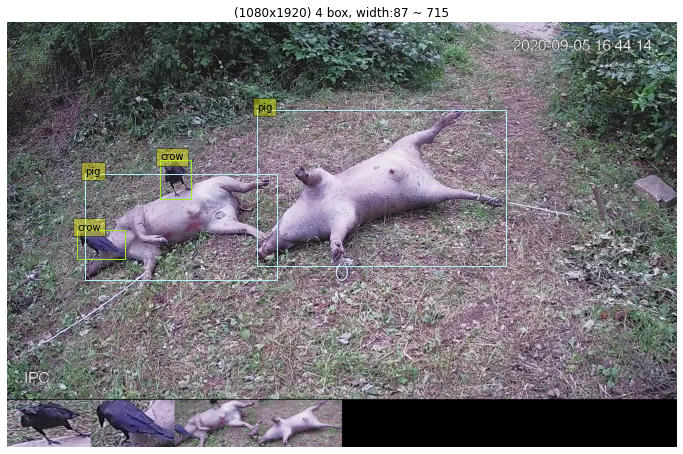

1 [1. 2.]


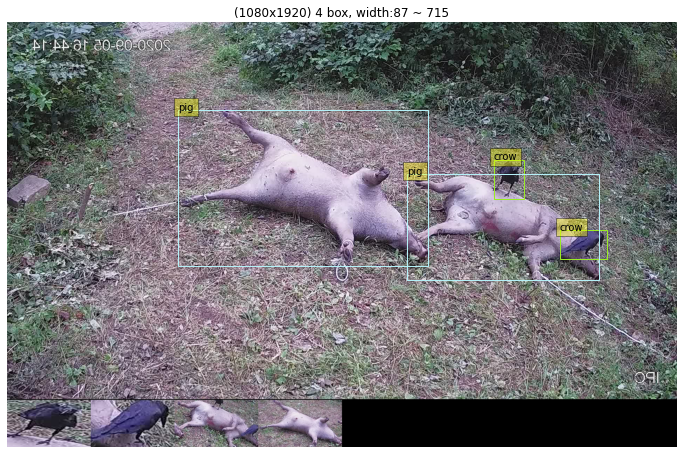

In [217]:
display_data(input_list_train, bbox_list_train, stride=1)

In [142]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""

def compute_iou(boxes1, boxes2):#compute_iou(anchor_boxes, gt_boxes)
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [143]:
level_end - level_start

4

In [265]:

"""
## Implementing Anchor generator
Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).
"""
class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.level_start = level_start
        self.level_end = level_end
        
        if anchor_k==9:
            self.aspect_ratios = [0.5, 1.0, 2.0]        
            self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        else:
            self.aspect_ratios = [1.0]        
            self.scales = [2 ** x for x in [0]]
                
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(self.level_start, self.level_end)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 196.0, 256.0]]                        
        self._areas = self._areas[:level_end - level_start]
        
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - self.level_start]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - self.level_start], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return tf.concat(anchors, axis=0)
    
    def get_anchors_check(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return anchors

In [266]:
level_start, level_end

(5, 8)

In [267]:
anchor_check = AnchorBox()

In [268]:
anchors = anchor_check.get_anchors_check(128,128)
for anchor in anchors:
    print(anchor.shape, anchor[-1])

(144, 4) tf.Tensor([112.    112.     71.838  35.919], shape=(4,), dtype=float32)
(36, 4) tf.Tensor([ 96.     96.    143.675  71.838], shape=(4,), dtype=float32)
(9, 4) tf.Tensor([ 64.     64.    287.35  143.675], shape=(4,), dtype=float32)


In [269]:
padded_image_shape, 128*8

((1024, 1920), 1024)

In [270]:
"""
## Preprocessing data
Preprocessing the images involves two steps:
- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.
Along with the images, bounding boxes are rescaled and flipped if required.
"""

def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
   
    return image, boxes

def random_flip_vertical(image, boxes):
    is_flipped = tf.zeros_like(boxes[:, 0])
    if tf.random.uniform(()) > 10.5:
        image = tf.image.flip_up_down(image)        
        boxes = tf.stack([boxes[:, 0], 1 - boxes[:, 3], boxes[:, 2], 1 - boxes[:, 1]], axis=-1)
        is_flipped = tf.ones_like(is_flipped)
        
    return image, boxes, is_flipped

def resize_and_pad_image(
    image, mask_obj=None, min_side=1024.0, max_side=11333.0, jitter=[128*8, 128*8+1], stride=128.0
):
   
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    ratio = min_side / tf.reduce_min(image_shape)
    
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    if mask_obj!=None:
        mask_obj = tf.image.resize(mask_obj, tf.cast(image_shape, dtype=tf.int32))
    
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1]) 
    if mask_obj!=None:
        mask_obj = tf.image.pad_to_bounding_box(mask_obj, 0, 0, padded_image_shape[0], padded_image_shape[1])        
    if mask_obj!=None:
        return image, image_shape, ratio, mask_obj
    return image, image_shape, ratio

def resize_and_pad_image_bbox(#resize
    image, bbox, mask_obj=None, min_side=1024.0, max_side=1024.0*4, jitter=[128*7+32, 128*8-32], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    ratio_jitter = tf.random.uniform(tf.shape(image_shape), -32, 32, dtype=tf.float32)
    image_shape += ratio_jitter      
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    if mask_obj!=None:
        mask_obj = tf.image.resize(mask_obj, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1])
    if mask_obj!=None:
        mask_obj = tf.image.pad_to_bounding_box(mask_obj, 0, 0, padded_image_shape[0], padded_image_shape[1])        
    padded_image_shape = tf.cast(padded_image_shape, tf.float32)              
    pad_ratio = tf.cast(image_shape, tf.float32) / padded_image_shape
    bbox_padded = tf.stack(
        [
            bbox[:, 0] * pad_ratio[1],
            bbox[:, 1] * pad_ratio[0],
            bbox[:, 2] * pad_ratio[1],
            bbox[:, 3] * pad_ratio[0],
        ],
        axis=-1,
    )
    if mask_obj!=None:
        return image, padded_image_shape, ratio, bbox_padded, mask_obj    
    return image, padded_image_shape, ratio, bbox_padded


def preprocess_data(image, cls_bbox):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
     
    bbox = cls_bbox[:, 1:]
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)    

    image, bbox = random_flip_horizontal(image, bbox)
    image, bbox, is_flipped = random_flip_vertical(image, bbox)    
    is_flipped = tf.cast(is_flipped, tf.int32)
    image, image_shape, _, bbox = resize_and_pad_image_bbox(image, bbox)
    
    margin = 0#new
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1] + margin,
            bbox[:, 1] * image_shape[0] + margin,
            bbox[:, 2] * image_shape[1] - margin,
            bbox[:, 3] * image_shape[0] - margin,
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)    
    cls_flip = tf.stack((class_id, is_flipped), -1)
    return image, bbox, cls_flip


def preprocess_test_data(image, cls_bbox):         
    bbox = cls_bbox[:, 1:]
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)        
    
    image, image_shape, _ = resize_and_pad_image(image)
    is_flipped = tf.zeros_like(class_id)
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)    
    cls_flip = tf.stack((class_id, is_flipped), -1)
    return image, bbox, cls_flip


In [271]:
def image_color_augment(x):
    if tf.random.uniform(()) < -0.5:
        x_max = tf.reduce_max(x, [1, 2], True)
        x = x_max - x
    if tf.random.uniform(()) < -0.2:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((r, b, g), -1)
    elif tf.random.uniform(()) < -0.4:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((b, r, g), -1)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
    if tf.random.uniform(()) < -0.2:
        gray = tf.image.rgb_to_grayscale(x)
        x = tf.concat((gray, gray, gray), -1)        
    if tf.random.uniform(()) < -0.2:
        noise = tf.random.normal(tf.shape(x), stddev=tf.pow(tf.reduce_mean(x), 0.3))
        x += noise
    if tf.random.uniform(()) < 0.2:
        x = gaussian_filter2d(x, filter_shape=tuple(np.random.randint(1, 10, (2))), sigma=10)
        #x = gaussian_filter2d(x, filter_shape=np.random.randint(3, 10, (2)), sigma=10)
    if tf.random.uniform(()) < 0.2:        
        x = sharpness(x, factor=10)
   
            
    #x = tf.image.random_jpeg_quality(x, 0, 1.0)
    #x = tf.clip_by_value(x, 0, 1)
    
    return x

In [272]:
"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""

class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )    
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.4, ignore_iou=0.1
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)#from anchor to object-box        
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)    
        positive_mask = tf.greater_equal(max_iou, match_iou)# not only this, but also need max iou cell
        
        positive_proposal_mask = tf.greater_equal(iou_matrix, match_iou)
        positive_mask = tf.reduce_any(positive_proposal_mask, axis=1)
        
        negative_mask = tf.less(max_iou, ignore_iou)
        
        max_iou_anchor = tf.reduce_max(iou_matrix, axis=0, keepdims=True) 
        max_iou_anchor_mask = tf.greater_equal(iou_matrix, max_iou_anchor)
        positive_max_mask = tf.reduce_any(max_iou_anchor_mask, axis=1)
        positive_mask = tf.logical_or(positive_mask, positive_max_mask)#new      
        
        negative_mask = tf.logical_and(negative_mask, tf.logical_not(positive_mask))
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))        
        
        return (
            matched_gt_idx,            
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(positive_max_mask, dtype=tf.float32),            
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, positive_max_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        matched_gt_boxes_size = tf.reduce_prod(matched_gt_boxes[:, 2:], 1)
        matched_gt_boxes_size = tf.sqrt(matched_gt_boxes_size)        
        
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)    
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), 0.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -1.0, cls_target)       
        cls_target = tf.expand_dims(cls_target, axis=-1)        
        positive_max_mask= tf.expand_dims(positive_max_mask, -1)
        label = tf.concat([box_target, cls_target, positive_max_mask], axis=-1)        
        return label
    
    def encode_batch(self, batch_images, gt_boxes, cls_flip):
        """Creates box and classification targets for a batch"""
        #is_flipped 0 or 1
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]
        cls_ids, is_flipped = tf.split(cls_flip, 2, -1)
        cls_ids = tf.squeeze(cls_ids, -1)
        is_flipped = tf.squeeze(is_flipped, -1)
        is_flipped = tf.cast(is_flipped, tf.float32)
        
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        
        batch_images = tf.cast(batch_images, tf.float32)
        label = labels.stack()
        is_flipped_anchor = tf.zeros_like(label[:, :, :1]) + tf.reduce_max(is_flipped)
        label = tf.concat((label, is_flipped_anchor), -1)
        return batch_images, label
      
    
    def encode_batch_train(self, batch_images, gt_boxes, cls):
        """Creates box and classification targets for a batch"""
        
        batch_images = image_color_augment(batch_images)#new        
        return self.encode_batch(batch_images, gt_boxes, cls)

In [273]:
#https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

In [274]:
def coordinate_map_uv(h, w):
    #return (6, 18, 256)
    x = tf.range(0.5, w, 1) / tf.cast(w, tf.float32) * 2.0 -1
    y = tf.range(0.5, h, 1) / tf.cast(h, tf.float32) * 2.0 -1
    X, Y = tf.meshgrid(x, y)
    xy = tf.stack((X, Y), -1)
    xy = tf.expand_dims(xy, axis=0)   
    return xy 

def coordinate_map_y(h):
    #return (6, 18, 256)    
    y = tf.range(0.5, h, 1) / tf.cast(h, tf.float32)
    y = tf.reshape(y, [1, h, 1, 1])
    return y

def fusion(net):
    net0, net1 = tf.split(net, 2, -1)
    shape = tf.shape(net0)
    a = coordinate_map_y(shape[1])    
    net = (1 - a) * net0 + a * net1
    return net

In [276]:
regulizer = tf.keras.regularizers.L2(l1)

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters, 
               activation=activation,
               padding="same",
               groups = 1,
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(x)    
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same",
               groups = 2,
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(y)
   
    if downsample:
        x = Conv2D(kernel_size=3,
                   strides=2,
                   filters=filters,
                   activation=activation,
                   padding="same",
                   kernel_regularizer=regulizer)(x)
    out = Add()([x, y])
    out = ReLU()(out)
    return out


def create_resnet_backbone(inputs):
    
    #inputs = Input(shape=(None, None, 3))    
    num_filters = 64
    
    #t = BatchNormalization()(inputs)    
    input_min = tf.reduce_min(inputs, [1,2], True)
    input_max = tf.reduce_max(inputs, [1,2], True)
    input_norm = (inputs - input_min)/(input_max - input_min)
    t = Conv2D(kernel_size=3,
               strides=2,
               filters=num_filters,
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(input_norm)
    
    #t0, t1 = tf.split(t, 2, -1)
    #t = fusion(t0, t1)
    #t = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(t)
    
    #t_height = tf.shape(t)[1]
    #num_blocks_list = [2, 2, 2, 2]#resnet-18
    #num_blocks_list = [3, 4, 6, 3]#resnet-34
    #num_blocks_list = [3, 4, 2, 2]#resnet-24
    num_blocks_list = [3, 4, 2, 1]#resnet-22
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=-1), filters=num_filters)
        if i>=1:
            t_list.append(t)
        num_filters *= 2    
        
    return t_list

In [277]:
def BifeaturePyramidNet(c345):
    regulizer  = tf.keras.regularizers.L2(l1)
    filters = 256    
    a2 = c345[0]
    a3 = c345[1]
    a4 = c345[2]
    a5 = c345[3]
    a6 = Conv2D(filters, 3, 2, "same", activation=activation, kernel_regularizer=regulizer)(a5)
    a7 = Conv2D(filters, 3, 2, "same", activation=activation, kernel_regularizer=regulizer)(a6)
    
    #b3 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #b4 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    a2_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a2)
    #a3_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #a4_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    #a3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #a4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    a33 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    a44 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    a55 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a5)
    a66 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a6)
    a3_0, a3_1 = tf.split(a33, 2, -1)
    a4_0, a4_1 = tf.split(a44, 2, -1)
    a5_0, a5_1 = tf.split(a55, 2, -1)
    a6_0, a6_1 = tf.split(a66, 2, -1)
    
    a7_up = keras.layers.UpSampling2D(2)(a7)    
    b6 = keras.layers.Add()([a6_0, a7_up])  
    
    a6_up = keras.layers.UpSampling2D(2)(a6_0)    
    b5 = keras.layers.Add()([a5_0, a6_up])  
    
    a5_up = keras.layers.UpSampling2D(2)(a5_0)    
    b4 = keras.layers.Add()([a4_0, a5_up])  
    
    b4_up = keras.layers.UpSampling2D(2)(b4)
    b3 = keras.layers.Add()([a3_0, b4_up])  
    
    b3_up = keras.layers.UpSampling2D(2)(b3)
    b2 = keras.layers.Add()([a2_0, b3_up])
    
    b2_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(b2)
    b3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(b3)    
    c3 = keras.layers.Add()([a3_1, b3_1, b2_down])
    
    c3_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(c3)
    b4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(b4)    
    c4 = keras.layers.Add()([a4_1, b4_1, c3_down])
    
    c4_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(c4)
    b5_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(b5)    
    c5 = keras.layers.Add()([a5_1, b5_1, c4_down])    
    
    c5_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(c5) 
    b6_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(b6)    
    c6 = keras.layers.Add()([a6, b6_1, c5_down]) 
    
    c6_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(c6)
    c7 = keras.layers.Add()([a7, c6_down]) 
    
    return c3, c4, c5, c6, c7

In [278]:
#https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/image/__init__.py
from tensorflow_addons.image.color_ops import sharpness
from tensorflow_addons.image.filters import gaussian_filter2d
from tensorflow_addons.image.dense_image_warp import dense_image_warp

inputs = Input(shape=(3, 3, 2))  # 18   
outputs = Conv2D(10, 3)(inputs)# 18 * 10 + 10 = 190
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

In [279]:
backbone = keras.applications.EfficientNetB2(include_top=False, input_shape=[128, 128, 3])
backbone.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, 128, 128, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
normalization_7 (Normalization) (None, 128, 128, 3)  7           rescaling_7[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization_7[0][0]            
_____________________________________________________________________________________

inputs = Input(shape=(3, 3, 2))      # 9 + 9
outputs = Conv2D(10, 3, groups=2)(inputs) # 9*5 + 5 + 9*5 + 5
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


In [280]:
def get_backbone():
    backbone = keras.applications.EfficientNetB2(include_top=False, input_shape=[None, None, 3])
    c2_output, c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["block2c_add", "block3c_add", "block5d_add",'block6e_add']]#block5c_add, block6d_add
    #c4_output = (c4_output + c4a_output[:, :, :, :80])/2
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c2_output, c3_output, c4_output, c5_output]
    )
backbone = get_backbone()
#D0 for layer_name in ["block2b_add", "block3b_add", "block5c_add", "block6d_add"]]
#D7 for layer_name in ["block2f_add", "block3g_add", "block5j_add", "block6d_add"]]
#input                           (None, 64, 64, 3)   
#block2b_add (Add)               (None, 16, 16, 24) 
#block3b_add (Add)               (None, 8, 8, 40)    
#block4c_add (Add)               (None, 4, 4, 80)
#block5c_add (Add)               (None, 4, 4, 112) 
#block6d_add (Add)               (None, 2, 2, 192)

In [281]:
backbone.trainable = False

In [282]:
backbone.summary()

Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, None, None, 3 0           input_14[0][0]                   
__________________________________________________________________________________________________
normalization_8 (Normalization) (None, None, None, 3 7           rescaling_8[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_8[0][0]            
______________________________________________________________________________________

def get_backbone():
    backbone = keras.applications.MobileNetV2(include_top=False, input_shape=[None, None, 3])
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["block_6_expand_relu", "block_13_expand_relu", "out_relu"]]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )
backbone = get_backbone()

In [283]:
level_start, level_end

(5, 8)

In [288]:
def createRetinaNet(num_classes, anchor_k, is_train=False):
    prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
    inputs = Input(shape=(None, None, 3))        
    
    nets_3 = backbone(inputs, training=is_train)    
    #nets_3 = create_resnet_backbone(inputs / 255)            
    features = BifeaturePyramidNet(nets_3)    
    
    cls_outputs = []
    box_outputs = []
   
    kernel_init = tf.initializers.he_normal()
    regulizer = tf.keras.regularizers.L2(l1)
    conv_c0 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_c1 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_c2 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_c3 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_c4 = keras.layers.Conv2D(anchor_k * num_classes, 3, 1, padding="same", kernel_initializer=kernel_init, bias_initializer=prior_probability)   
    
    conv_b0 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_b1 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_b2 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_b3 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_b4 = keras.layers.Conv2D(anchor_k * 4, 3, 1, padding="same", kernel_initializer=kernel_init, bias_initializer="zeros")   
    drop = keras.layers.Dropout(0.1)
    
    cbox_outputs = []
    N = tf.shape(inputs)[0]# TFLite cannot convert tf.shape() function
    #N = 1
        
    for i in range(2, len(features)):                    
        feature = features[i]
        box_out = conv_b4(drop(conv_b3(conv_b2(conv_b1(conv_b0(feature))))))
        cls_out = conv_c4(drop(conv_c3(conv_c2(conv_c1(conv_c0(feature))))))
        
        box_out = tf.reshape(box_out, [N, -1, 4])
        cls_out = tf.reshape(cls_out, [N, -1, num_classes])
        
        cbox_out = tf.concat((box_out, cls_out), axis=-1)#new        
        cbox_outputs.append(cbox_out)
    
    outputs = tf.concat(cbox_outputs, axis=1)  
    
    model = keras.Model(inputs=inputs, outputs=outputs)#dual    
    
    return model


In [289]:
def _decode_box_predictions(anchor_boxes, box_predictions):
    _box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    boxes = box_predictions * _box_variance
    boxes = tf.concat(
        [
            boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
            tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
        ],
        axis=-1,
    )
    boxes_transformed = convert_to_corners(boxes)
    return boxes_transformed

def decodePredictions(images, predictions, 
                      num_classes=num_classes,
                      confidence_threshold=0.5,
                      nms_iou_threshold=0.2,
                      max_detections_per_class=1000,
                      max_detections=1500,
                      box_variance=[0.1, 0.1, 0.2, 0.2]):
    
    _anchor_box = AnchorBox()
        
    image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
    image_h = padded_image_shape[0]
    image_w = padded_image_shape[1]
    #anchor_boxes = _anchor_box.get_anchors(image_shape[1], image_shape[2])
    anchor_boxes = _anchor_box.get_anchors(image_h, image_w)
    box_predictions = predictions[:, :, :4]
    objectness = tf.nn.sigmoid(predictions[:, :, 4:5])
    cls_score = predictions[:, :, 5:5+num_classes_real]
    cls_prob = tf.nn.softmax(cls_score)
    cls_prob_max = tf.reduce_max(cls_prob, -1)
    #cls_predictions = tf.round(objectness) * cls_predictions         
    #cls_predictions = objectness
    cls = tf.argmax(cls_score, -1)
    cls = tf.cast(cls, tf.float32)
    
    boxes = _decode_box_predictions(anchor_boxes[None, ...], box_predictions)
    boxes_2d = tf.reshape(boxes, [-1, 4])    
    scores = tf.reshape(objectness, [-1, 1])#new
    #scores = tf.sqrt(scores * tf.reshape(cls_prob_max, [-1, 1]))#new
    cls = tf.reshape(cls, [-1, 1])
    ccbox = tf.concat((cls, scores, boxes_2d), -1)
    
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(    
        ccbox[:, 2:],
        ccbox[:, 1],        
        max_detections,
        nms_iou_threshold,
        confidence_threshold,        
    )
    output = tf.gather(ccbox, selected_indices)        
    return output   

In [290]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):    
        
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        loss = tf.where(loss < 0.01, 0.0, loss)#new marginal loss        
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma, num_classes):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma
        self._num_classes = num_classes

        
    def call(self, y_cls, y_pred):
        y_cls = tf.cast(y_cls, dtype=tf.int32)
        y_hot = tf.one_hot(y_cls, depth=self._num_classes, dtype=tf.float32,)
        is_exist_non_human_class = tf.reduce_any(y_cls > 1)
        y_positive = tf.cast(y_cls > 0, tf.float32)          
        obj_score = tf.identity(y_pred[:, :, 0], name='obj_score')
        objectness = obj_score + tf.reduce_mean(y_pred[:, :, 1:]*0, axis=-1)
       
        pt = tf.nn.sigmoid(objectness)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)
                
        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_positive * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (1 - y_positive) * tf.math.log(1 - pt)
        loss_obj = loss_p + loss_f
        #loss_obj = tf.where(loss_obj < 0.01, 0.0, loss_obj)#new
        
        y_hot = y_hot[:, :, :num_classes_real]
        cls_pt = tf.nn.softmax(y_pred[:, :, 1:1+num_classes_real])        
        cls_pt = tf.clip_by_value(cls_pt, 1e-7, 1.0 - 1e-7)
        loss_cls_p = - tf.pow(1.0 - cls_pt, self._gamma) * y_hot * tf.math.log(cls_pt)
        loss_cls_f = - tf.pow(cls_pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - cls_pt)
        loss_cls = tf.reduce_sum(loss_cls_p + loss_cls_f, axis=-1)        
        loss_cls = y_positive * loss_cls
        loss = self._gamma * (loss_obj + loss_cls)
        return loss
    
class RetinaNetFlipLoss(tf.losses.Loss):
    def __init__(self):
        super(RetinaNetFlipLoss, self).__init__(reduction="auto", name="RetinaNetFlipLoss")
    
    def call(self, y, h):
        pt = tf.nn.sigmoid(h)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)
        gamma = 2.0
        loss_p = - tf.pow(1.0 - pt, gamma) * y * tf.math.log(pt)        
        loss_f = - tf.pow(pt, gamma) * (1 - y) * tf.math.log(1 - pt)       
        loss = loss_p + loss_f
        return loss
    
class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.2, gamma=2.0, delta=1.0):#alpha=0.25
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma, num_classes-1)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._flip_loss = RetinaNetFlipLoss()        
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # y_pred : tf.concat([box_outputs, cls_outputs], axis=-1)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        box_labels = y_true[:, :, :4]
        y_cls = y_true[:, :, 4]
        positive_max_mask = y_true[:, :, 5] > 0#new
        
        box_predictions = y_pred[:, :, :4]
        h_obj = tf.nn.sigmoid(y_pred[:, :, 4])        
        cls_predictions = y_pred[:, :, 4:-1]        
        
        y_flipped = y_true[:, :, 6]
        h_flipped = y_pred[:, :, -1]               
    
        positive_mask = tf.greater(y_cls, 0.0)
        ignore_mask = tf.less(y_cls, 0.0)
        
        clf_loss = self._clf_loss(y_cls, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions) 
        flip_loss = self._flip_loss(y_flipped, h_flipped)
                        
        clf_loss = tf.where(ignore_mask, 0.0, clf_loss)        
        box_loss = tf.where(positive_mask, box_loss, 0.0)
        flip_loss = tf.where(positive_mask, flip_loss, 0.0)
        
        max_alpha = 0.2
        clf_loss = tf.where(positive_max_mask, (1 + max_alpha) * clf_loss, (1 - max_alpha) * clf_loss)        
        box_loss = tf.where(positive_max_mask, (1 + max_alpha) * box_loss, (1 - max_alpha) * box_loss)
        #box_loss = tf.where(tf.logical_and(h_obj > 0.5, positive_max_mask), box_loss, 0.0)#new    
        
        positive_mask = tf.cast(positive_mask, tf.float32)
        
        normalizer = tf.reduce_sum(positive_mask, axis=-1)                
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        flip_loss = tf.math.divide_no_nan(tf.reduce_sum(flip_loss, axis=-1), normalizer)
        loss = (1 + max_alpha) * clf_loss + box_loss + flip_loss
        return loss 

In [291]:
def recall(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]
    h_prob = tf.nn.sigmoid(h_score)    
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    
    true_positives = tf.cast(tf.logical_and(y_cls > 0, h_postive>0), tf.float32)
    false_negative = y_positive * (1 - h_postive)
                
    tp = tf.reduce_sum(true_positives, axis=1)
    fn = tf.reduce_sum(false_negative, axis=1)
    tp = tf.cast(tp, tf.float32)
    fn = tf.cast(fn, tf.float32)
    
    rec = tp / (tp + fn + 1e-8)
    return rec

def precision(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)    
    y_cls_symbol = tf.cast(y_cls_symbol != 0, tf.int32)
    h_obj_prob = tf.nn.sigmoid(y_pred[:, :, 4])
    h_cls_symbol = tf.round(h_obj_prob)    
    h_cls_symbol = tf.cast(h_cls_symbol, tf.int32)
    
    true_positives = y_cls_symbol * h_cls_symbol
    false_positive = (1 - y_cls_symbol) * h_cls_symbol
    
    ones = tf.ones_like(true_positives)
    zeeros = tf.zeros_like(true_positives)
    true_positives = tf.cast(tf.equal(true_positives, ones), tf.float32)
    false_positive = tf.cast(tf.equal(false_positive, ones), tf.float32)
    
    tp = tf.reduce_sum(true_positives, axis=1)
    fp = tf.reduce_sum(false_positive, axis=1)
    tp = tf.cast(tp, tf.float32)
    fp = tf.cast(fp, tf.float32)
    prec = tp / (tp + fp + 1e-8)
    return prec

def accuracy(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = y_cls > 0
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]        
    h_prob = tf.nn.sigmoid(h_score)
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    h_cls = tf.math.argmax(y_pred[:, :, 5:5+num_classes_real], -1, output_type=tf.int32)        
    acc = tf.boolean_mask(tf.equal(y_cls, h_cls), y_positive)    
    return acc

def flip_accuracy(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_flip = tf.cast(y_true[:, :, 6], tf.int32)
    y_positive = y_cls > 0
    h_prob = tf.nn.sigmoid(y_pred[:, :, -1])
    h_flip = tf.cast(tf.round(h_prob), tf.int32)    
    acc = tf.boolean_mask(tf.equal(y_flip, h_flip), y_positive)    
    #acc = tf.reduce_mean(tf.cast(acc, tf.float32))
    return acc

In [292]:
label_encoder = LabelEncoder()
anchor_k = len(label_encoder._anchor_box.aspect_ratios)*len(label_encoder._anchor_box.scales)

In [293]:
def generator():    
    for i in range(len(input_list_train)):
        x = input_list_train[i]
        y_box = bbox_list_train[i]                
        yield (x, y_box)

def generator_test():    
    for i in range(len(input_list_test)):
        x = input_list_test[i]
        y_box = bbox_list_test[i]        
        yield (x, y_box)

dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))
dataset_test = tf.data.Dataset.from_generator(
    generator_test, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))

np.set_printoptions(precision=2)
for example in tfds.as_numpy(dataset):
    image = example[0]
    bbox = example[1]
    print(image.dtype, image.shape, bbox.shape, bbox[0])
    break

uint8 (1080, 1920, 3) (4, 5) [2.   0.23 0.36 0.27 0.47]


In [294]:
batch_size = 2 # 16 OOM
autotune = tf.data.experimental.AUTOTUNE

In [295]:
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
#train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=False)
#train_dataset = train_dataset.padded_batch(batch_size=batch_size)
train_dataset = train_dataset.map(label_encoder.encode_batch_train, num_parallel_calls=autotune)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

In [296]:
val_dataset = dataset_test.map(preprocess_test_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=False)
#val_dataset = val_dataset.padded_batch(batch_size=batch_size)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

In [297]:
np.set_printoptions(precision=3, linewidth=200)
image_height, image_width = padded_image_shape

img_check = 0
for image, output_map in train_dataset:
    print('output_map', output_map.shape)
    cbbox = output_map    
    bbox = cbbox[:, :, :4]
    cls_gt = cbbox[:,:,4]
    img_m, image_height, image_width, image_ch = image.shape
    anchor_feature_size = [(np.ceil(image_height / 2 ** i), np.ceil(image_width / 2 ** i)) 
                           for i in range(level_start, level_end)]
    print('anchor_feature_size', anchor_feature_size)    
    m = len(cbbox)    
    positive_count = np.sum(cls_gt>0)
    print('cbbox', cbbox.shape)
    print('cls_sum',np.sum(cls_gt < 0.0), np.sum(cls_gt == 0.0), 
          np.sum(cls_gt == 1.0), np.sum(cls_gt > 1.0))
    print('cls_mean',np.mean(cls_gt < 0.0), np.mean(cls_gt == 0.0), 
          np.mean(cls_gt == 1.0), np.mean(cls_gt > 0.0))
    print('shape',image.shape, cbbox.shape,'unique', np.unique(cls_gt))
    print('anchor_feature_size', anchor_feature_size)
    offset = 0
    positive_maps = []
    for anchor_feature_size_1 in anchor_feature_size:        
        fm_h, fm_w = anchor_feature_size_1
        fm_h = int(fm_h)
        fm_w = int(fm_w)        
        fm_wh = int(fm_h * fm_w * anchor_k)
        cbbox_anchor = cbbox[:, offset:offset+fm_wh, 4]
        cbbox_anchor = np.reshape(cbbox_anchor, [m, fm_h, fm_w, anchor_k])
        coount_m1 = np.count_nonzero(cbbox_anchor==-1)
        coount_0 = np.count_nonzero(cbbox_anchor==0)
        coount_1 = np.count_nonzero(cbbox_anchor==1)
        coount_1_over = np.count_nonzero(cbbox_anchor>1)
        positive_ratio = np.mean(cbbox_anchor>0)
        positive_maps.append(cbbox_anchor>0)
        print('cbbox_anchor', cbbox_anchor.shape, coount_m1, coount_0, coount_1, coount_1_over, 'ratio', positive_ratio)
        sample_0_cbbox = cbbox_anchor[0]
        sample_0_cbbox_sum = np.max(sample_0_cbbox, -1).astype(np.int)       
      
        offset += fm_wh
        if False:            
            file_name = str(fm_h)+ '_' + str(fm_w)+ '.txt'
            np.savetxt(file_name,sample_0_cbbox_sum, fmt='%d',delimiter='')
    img_check = image
    break

output_map (2, 21168, 7)
anchor_feature_size [(32.0, 56.0), (16.0, 28.0), (8.0, 14.0)]
cbbox (2, 21168, 7)
cls_sum 581 41717 12 26
cls_mean 0.013723544973544973 0.985378873771731 0.0002834467120181406 0.0008975812547241119
shape (2, 1024, 1792, 3) (2, 21168, 7) unique [-1.  0.  1.  2.]
anchor_feature_size [(32.0, 56.0), (16.0, 28.0), (8.0, 14.0)]
cbbox_anchor (2, 32, 56, 9) 243 32013 0 0 ratio 0.0
cbbox_anchor (2, 16, 28, 9) 111 7930 0 23 ratio 0.0028521825396825395
cbbox_anchor (2, 8, 14, 9) 227 1774 12 3 ratio 0.00744047619047619


Text(0.5, 1.0, '(2, 32, 56, 9)0.0 0')

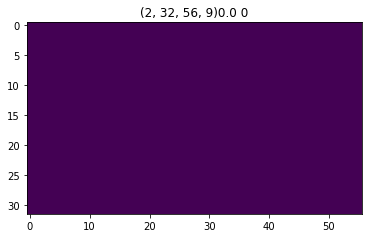

In [298]:
plt.imshow(np.max(positive_maps[0][0], -1))
plt.title(str(positive_maps[0].shape)+ str(np.mean(positive_maps[0][0]))+ ' ' + str(np.sum(positive_maps[0][0])))

In [301]:
pmap0 = np.array(Image.fromarray(np.max(positive_maps[0][0],-1)).resize((image_width, image_height)))
pmap1 = np.array(Image.fromarray(np.max(positive_maps[1][0],-1)).resize((image_width, image_height)))
pmap2 = np.array(Image.fromarray(np.max(positive_maps[2][0],-1)).resize((image_width, image_height)))
#pmap3 = np.array(Image.fromarray(np.max(positive_maps[3][0],-1)).resize((image_width, image_height)))
#pmap4 = np.array(Image.fromarray(np.max(positive_maps[4][0],-1)).resize((image_width, image_height)))
pmap0 = pmap0.astype(np.uint8)
pmap1 = pmap1.astype(np.uint8)
pmap2 = pmap2.astype(np.uint8)
pmap3 = 0#pmap3.astype(np.uint8)
pmap4 = 0#pmap4.astype(np.uint8)

Text(0.5, 1.0, '0.08705357142857142')

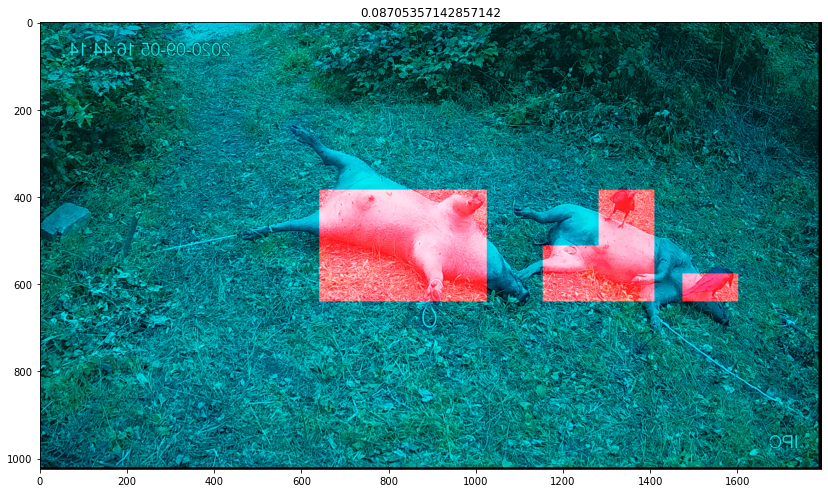

In [302]:
pmap_with_img = np.array(img_check)[0]#*255
pmap_with_img = pmap_with_img.astype(np.uint8)
pmap_add = np.expand_dims(pmap0+pmap1+pmap2+pmap3+pmap4, -1)
pmap = (pmap_add>0).astype(np.uint8)*255
mix_rgb = np.concatenate((pmap, pmap_with_img[:,:,1:]),-1)
plt.figure(figsize=(14,14))
plt.imshow(mix_rgb)
plt.title(str(np.mean(pmap_add)))

In [305]:
def load_weight():   
    weights_dir = path_weight#"data"
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir)

In [309]:
optimizer = tf.optimizers.SGD(learning_rate=1e-5, momentum=0.1, clipvalue=5.)#warm up clipvalue=10. !
#optimizer = tf.optimizers.SGD(learning_rate=1e-3, momentum=0.1, clipvalue=10.)
loss_detect = RetinaNetLoss(num_classes)
model = createRetinaNet(num_classes, anchor_k)
metrics = [recall, precision, accuracy]
model.compile(loss=loss_detect, optimizer=optimizer, metrics=metrics)#[recall, precision, accuracy]
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_weight,
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=0,
        save_freq=200
    )
]

In [307]:
load_weight()
print(len(input_list_train), len(input_list_test))

latest_checkpoint retinanet/pig_efficient_det_BiFPN_D2

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0893706340> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f089372fbe0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0893994520> and <tensorflow.python.keras.layers.merge.Add object at 0x7f08936f9b50>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f08936c0ca0> and <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x7f0893729790>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0893680be0> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f08936c0ca0>).


ValueError: Shapes (512,) and (256,) are incompatible

In [76]:
out = model.evaluate(val_dataset.take(1000))
'''

'''

549/549 [==============================] - 51s 48ms/step - loss: 7.2216 - recall: 0.9335 - precision: 0.9731 - accuracy: 0.9438 - flip_accuracy: 0.0020


In [313]:
epochs = 10000
hist = model.fit(
    train_dataset.take(10000),
    validation_data=None,#val_dataset.take(2)
    epochs=epochs, 
    callbacks=callbacks_list,#callbacks_list
    verbose=2,
)
'''
effD2 Freeze:652ms/step - loss: 0.8893 - recall: 0.9685 - precision: 0.9854 - accuracy: 0.9676 - flip_accuracy: 0.9951
'''

Epoch 1/10000
1/1 - 0s - loss: 16.2513 - recall: 0.4736 - precision: 0.3754 - accuracy: 0.8966
Epoch 2/10000
1/1 - 0s - loss: 10.9019 - recall: 0.6627 - precision: 0.4138 - accuracy: 0.9375
Epoch 3/10000
1/1 - 0s - loss: 9.7543 - recall: 0.5714 - precision: 0.3194 - accuracy: 0.9643
Epoch 4/10000
1/1 - 0s - loss: 8.8319 - recall: 0.7179 - precision: 0.3860 - accuracy: 0.9677
Epoch 5/10000
1/1 - 0s - loss: 7.4685 - recall: 0.6569 - precision: 0.4150 - accuracy: 1.0000
Epoch 6/10000
1/1 - 0s - loss: 10.2587 - recall: 0.4637 - precision: 0.3721 - accuracy: 0.9355
Epoch 7/10000
1/1 - 0s - loss: 10.2630 - recall: 0.6000 - precision: 0.3532 - accuracy: 1.0000
Epoch 8/10000
1/1 - 0s - loss: 11.7790 - recall: 0.3641 - precision: 0.3741 - accuracy: 0.9286
Epoch 9/10000
1/1 - 0s - loss: 8.3474 - recall: 0.8062 - precision: 0.4888 - accuracy: 0.9677
Epoch 10/10000
1/1 - 0s - loss: 13.9246 - recall: 0.4182 - precision: 0.3801 - accuracy: 0.9583
Epoch 11/10000
1/1 - 0s - loss: 9.0533 - recall: 0.56

Epoch 87/10000
1/1 - 0s - loss: 7.2474 - recall: 0.8571 - precision: 0.5096 - accuracy: 1.0000
Epoch 88/10000
1/1 - 0s - loss: 6.7459 - recall: 0.7333 - precision: 0.5295 - accuracy: 1.0000
Epoch 89/10000
1/1 - 0s - loss: 7.5187 - recall: 0.8125 - precision: 0.4980 - accuracy: 0.9667
Epoch 90/10000
1/1 - 0s - loss: 7.5604 - recall: 0.7386 - precision: 0.5545 - accuracy: 1.0000
Epoch 91/10000
1/1 - 0s - loss: 9.1257 - recall: 0.6258 - precision: 0.5141 - accuracy: 1.0000
Epoch 92/10000
1/1 - 0s - loss: 9.1379 - recall: 0.5048 - precision: 0.4737 - accuracy: 0.9655
Epoch 93/10000
1/1 - 0s - loss: 9.5754 - recall: 0.3709 - precision: 0.4224 - accuracy: 0.9259
Epoch 94/10000
1/1 - 0s - loss: 8.2019 - recall: 0.3810 - precision: 0.4031 - accuracy: 0.9655
Epoch 95/10000
1/1 - 0s - loss: 8.5518 - recall: 0.6548 - precision: 0.4805 - accuracy: 0.9310
Epoch 96/10000
1/1 - 0s - loss: 7.6817 - recall: 0.8504 - precision: 0.5204 - accuracy: 1.0000
Epoch 97/10000
1/1 - 0s - loss: 7.0077 - recall: 0

Epoch 173/10000
1/1 - 0s - loss: 11.6050 - recall: 0.5224 - precision: 0.4792 - accuracy: 0.9600
Epoch 174/10000
1/1 - 0s - loss: 10.0984 - recall: 0.5905 - precision: 0.4179 - accuracy: 1.0000
Epoch 175/10000
1/1 - 0s - loss: 9.0658 - recall: 0.5283 - precision: 0.4545 - accuracy: 0.9459
Epoch 176/10000
1/1 - 0s - loss: 9.3369 - recall: 0.6184 - precision: 0.3987 - accuracy: 0.9429
Epoch 177/10000
1/1 - 0s - loss: 11.9975 - recall: 0.6250 - precision: 0.4082 - accuracy: 0.9375
Epoch 178/10000
1/1 - 0s - loss: 7.8978 - recall: 0.4667 - precision: 0.3813 - accuracy: 0.9667
Epoch 179/10000
1/1 - 0s - loss: 13.0803 - recall: 0.3929 - precision: 0.4208 - accuracy: 0.9444
Epoch 180/10000
1/1 - 0s - loss: 7.9017 - recall: 0.7468 - precision: 0.4965 - accuracy: 1.0000
Epoch 181/10000
1/1 - 0s - loss: 9.0251 - recall: 0.5750 - precision: 0.3701 - accuracy: 1.0000
Epoch 182/10000
1/1 - 0s - loss: 6.8776 - recall: 0.8179 - precision: 0.4881 - accuracy: 1.0000
Epoch 183/10000
1/1 - 0s - loss: 9.7

Epoch 259/10000
1/1 - 0s - loss: 5.3292 - recall: 1.0000 - precision: 0.6026 - accuracy: 1.0000
Epoch 260/10000
1/1 - 0s - loss: 6.0187 - recall: 0.7868 - precision: 0.6667 - accuracy: 0.9697
Epoch 261/10000
1/1 - 0s - loss: 7.6022 - recall: 0.3538 - precision: 0.5464 - accuracy: 0.9286
Epoch 262/10000
1/1 - 0s - loss: 5.0002 - recall: 0.7350 - precision: 0.7062 - accuracy: 1.0000
Epoch 263/10000
1/1 - 0s - loss: 8.1816 - recall: 0.3705 - precision: 0.6168 - accuracy: 0.9333
Epoch 264/10000
1/1 - 0s - loss: 6.6723 - recall: 0.8304 - precision: 0.6087 - accuracy: 1.0000
Epoch 265/10000
1/1 - 0s - loss: 6.0455 - recall: 0.7262 - precision: 0.5427 - accuracy: 1.0000
Epoch 266/10000
1/1 - 0s - loss: 5.2123 - recall: 0.8824 - precision: 0.5962 - accuracy: 0.9615
Epoch 267/10000
1/1 - 0s - loss: 5.6784 - recall: 0.9081 - precision: 0.6679 - accuracy: 0.9697
Epoch 268/10000
1/1 - 0s - loss: 7.0038 - recall: 0.7758 - precision: 0.5482 - accuracy: 1.0000
Epoch 269/10000
1/1 - 0s - loss: 10.8646

Epoch 345/10000
1/1 - 0s - loss: 6.3670 - recall: 0.6190 - precision: 0.7368 - accuracy: 0.9565
Epoch 346/10000
1/1 - 0s - loss: 4.9016 - recall: 0.9412 - precision: 0.6539 - accuracy: 1.0000
Epoch 347/10000
1/1 - 0s - loss: 5.6143 - recall: 0.8299 - precision: 0.6938 - accuracy: 0.9706
Epoch 348/10000
1/1 - 0s - loss: 5.2049 - recall: 0.9021 - precision: 0.6497 - accuracy: 0.9677
Epoch 349/10000
1/1 - 0s - loss: 5.2028 - recall: 0.8873 - precision: 0.6452 - accuracy: 1.0000
Epoch 350/10000
1/1 - 0s - loss: 4.6126 - recall: 0.8684 - precision: 0.7020 - accuracy: 1.0000
Epoch 351/10000
1/1 - 0s - loss: 3.8244 - recall: 0.9444 - precision: 0.7153 - accuracy: 1.0000
Epoch 352/10000
1/1 - 0s - loss: 6.3133 - recall: 0.7912 - precision: 0.7000 - accuracy: 0.9259
Epoch 353/10000
1/1 - 0s - loss: 4.8599 - recall: 0.7824 - precision: 0.6147 - accuracy: 1.0000
Epoch 354/10000
1/1 - 0s - loss: 4.1128 - recall: 0.9149 - precision: 0.6993 - accuracy: 1.0000
Epoch 355/10000
1/1 - 0s - loss: 4.6010 

Epoch 431/10000
1/1 - 0s - loss: 8.7443 - recall: 0.3750 - precision: 0.5495 - accuracy: 1.0000
Epoch 432/10000
1/1 - 0s - loss: 4.3715 - recall: 0.8889 - precision: 0.6875 - accuracy: 0.9697
Epoch 433/10000
1/1 - 0s - loss: 6.8054 - recall: 0.4889 - precision: 0.6780 - accuracy: 1.0000
Epoch 434/10000
1/1 - 0s - loss: 4.1180 - recall: 0.9722 - precision: 0.7177 - accuracy: 1.0000
Epoch 435/10000
1/1 - 0s - loss: 5.8386 - recall: 0.5000 - precision: 0.5667 - accuracy: 1.0000
Epoch 436/10000
1/1 - 0s - loss: 4.4697 - recall: 0.8917 - precision: 0.7122 - accuracy: 1.0000
Epoch 437/10000
1/1 - 0s - loss: 7.4003 - recall: 0.7868 - precision: 0.7128 - accuracy: 0.9091
Epoch 438/10000
1/1 - 0s - loss: 4.6753 - recall: 0.9706 - precision: 0.7182 - accuracy: 1.0000
Epoch 439/10000
1/1 - 0s - loss: 4.3021 - recall: 0.9330 - precision: 0.7198 - accuracy: 1.0000
Epoch 440/10000
1/1 - 0s - loss: 7.8376 - recall: 0.5110 - precision: 0.5929 - accuracy: 1.0000
Epoch 441/10000
1/1 - 0s - loss: 7.0371 

Epoch 517/10000
1/1 - 0s - loss: 4.2628 - recall: 0.8640 - precision: 0.7089 - accuracy: 1.0000
Epoch 518/10000
1/1 - 0s - loss: 5.3610 - recall: 0.6875 - precision: 0.6302 - accuracy: 0.9062
Epoch 519/10000
1/1 - 0s - loss: 4.6036 - recall: 0.7411 - precision: 0.6992 - accuracy: 0.9667
Epoch 520/10000
1/1 - 0s - loss: 4.9554 - recall: 0.9349 - precision: 0.7125 - accuracy: 1.0000
Epoch 521/10000
1/1 - 0s - loss: 4.2007 - recall: 0.9055 - precision: 0.7231 - accuracy: 1.0000
Epoch 522/10000
1/1 - 0s - loss: 5.6210 - recall: 0.7611 - precision: 0.6620 - accuracy: 1.0000
Epoch 523/10000
1/1 - 0s - loss: 6.3715 - recall: 0.6683 - precision: 0.4968 - accuracy: 0.9655
Epoch 524/10000
1/1 - 0s - loss: 5.7928 - recall: 0.8199 - precision: 0.5661 - accuracy: 1.0000
Epoch 525/10000
1/1 - 0s - loss: 5.4830 - recall: 0.8046 - precision: 0.6266 - accuracy: 1.0000
Epoch 526/10000
1/1 - 0s - loss: 3.8572 - recall: 0.8846 - precision: 0.8050 - accuracy: 1.0000
Epoch 527/10000
1/1 - 0s - loss: 4.4736 

Epoch 603/10000
1/1 - 0s - loss: 5.5294 - recall: 0.7321 - precision: 0.6716 - accuracy: 0.9231
Epoch 604/10000
1/1 - 0s - loss: 3.6528 - recall: 1.0000 - precision: 0.8320 - accuracy: 1.0000
Epoch 605/10000
1/1 - 0s - loss: 4.7851 - recall: 0.8062 - precision: 0.6734 - accuracy: 0.9677
Epoch 606/10000
1/1 - 0s - loss: 5.6298 - recall: 0.5670 - precision: 0.6456 - accuracy: 0.9333
Epoch 607/10000
1/1 - 0s - loss: 3.3755 - recall: 0.9393 - precision: 0.7771 - accuracy: 1.0000
Epoch 608/10000
1/1 - 0s - loss: 3.5000 - recall: 0.9583 - precision: 0.6885 - accuracy: 1.0000
Epoch 609/10000
1/1 - 0s - loss: 2.9346 - recall: 1.0000 - precision: 0.8121 - accuracy: 1.0000
Epoch 610/10000
1/1 - 0s - loss: 3.5196 - recall: 0.9000 - precision: 0.7026 - accuracy: 1.0000
Epoch 611/10000
1/1 - 0s - loss: 5.1459 - recall: 0.6307 - precision: 0.6609 - accuracy: 1.0000
Epoch 612/10000
1/1 - 0s - loss: 3.5425 - recall: 0.9737 - precision: 0.7815 - accuracy: 1.0000
Epoch 613/10000
1/1 - 0s - loss: 3.5492 

KeyboardInterrupt: 

In [314]:
model.save_weights(path_weight)
path_weight

'retinanet/pig_efficient_det_BiFPN_D2'

In [315]:
image = tf.keras.Input(shape=[padded_image_shape[0], padded_image_shape[1], 3], name="image")
predictions = model(image, training=False)

detections = decodePredictions(image, predictions, confidence_threshold=0.5, nms_iou_threshold=0.1)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [316]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(12, 10), linewidth=1, color=[0, 0, 1], 
    boxes_gt=None):
    
    image = np.array(image, dtype=np.uint8)
    image = attach_crop_image(image, boxes, max_crop=200)        
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()        
   
    if boxes_gt is not None:
        for box in boxes_gt:        
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=[0,1,0], linewidth=2
            )
            ax.add_patch(patch)
            
    for box, cls, score in zip(boxes, classes, scores):        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        color_text = edgecolors[cls]
        color = [0, 0, 1]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 100:
            
            cls_name = class_names[cls] if cls < len(class_names) else 'unknown'
            score_txt = str.format('%s %.2f' %(cls_name, score))
            ax.text(x1, y1, score_txt, bbox={"facecolor": color_text, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
          
    plt.show()
    return ax

In [317]:
def check_test(test_datas, bboxs_label, step=1):
    i = 0
    for image, cbbox in test_datas: 
        if i%step==0:
            #cbbox = output_map["detect"]
            #mask_obj = output_map["segment"]  
            bbox_annotation = bboxs_label[i]
            scale = np.array(image.shape[:2])[::-1]
            scale = np.reshape(scale, [1, 2])
            scale = np.concatenate((scale, scale), 1)
            gt_bbox = bbox_annotation[ :, 1:] * scale
               
            input_image, _, ratio = resize_and_pad_image(image, jitter=None)
            input_image = tf.expand_dims(input_image, axis=0)
            #input_image = tf.cast(input_image, tf.uint8)
            detected_box = inference_model.predict(input_image)        
            print(input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio)
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
            #print('box', box)
            
            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )
        i+=1

(1, 1024, 1920, 3) detected_box (10, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)


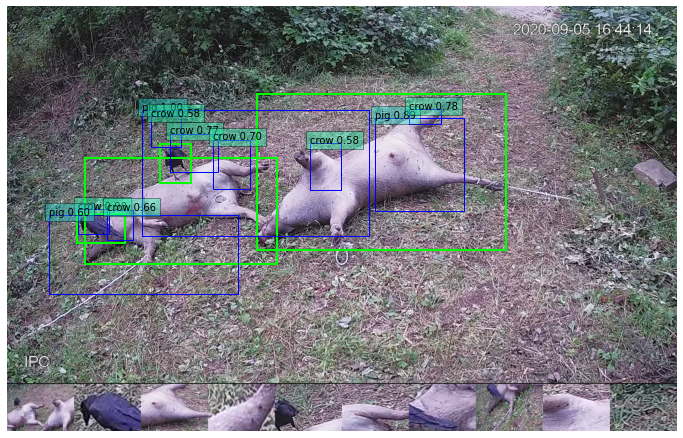

In [318]:
check_test(dataset, bbox_list_train, step=201)

Freeze Model

In [81]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [82]:
 # Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: inference_model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(inference_model.inputs[0].shape, inference_model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]


In [83]:
print(type(frozen_func.outputs))
frozen_list = frozen_func.outputs
print(frozen_list)
print(len(frozen_list))

print(type(frozen_func.inputs))
frozen_list = frozen_func.inputs
print(frozen_list)
print(len(frozen_list))

<class 'list'>
[<tf.Tensor 'Identity:0' shape=(None, 6) dtype=float32>]
1
<class 'list'>
[<tf.Tensor 'x:0' shape=(None, 1024, 1920, 3) dtype=float32>]
1


In [84]:
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="water_efficient_det_D2_frozen_graph.pb",
                  as_text=False)

'./frozen_models/frozen_graph.pb'

In [ ]:
def check_error(X, Y, Path, step=1):
    
    for i in range(len(X)): 
        image = X[i]
        bbox_annotation = Y[i]
        path = Path[i]
        
        scale = np.array(image.shape[:2])[::-1]
        scale = np.reshape(scale, [1, 2])
        scale = np.concatenate((scale, scale), 1)
        gt_bbox = bbox_annotation[:, 1:] * scale

        input_image, _, ratio = resize_and_pad_image(image, jitter=None)
        input_image = tf.expand_dims(input_image, axis=0)

        detected_box = inference_model.predict(input_image)
        detect_k = len(detected_box)
        if detect_k!= len(bbox_annotation):
            print(path, input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio.numpy())
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
            #print('box', box)

            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )
        

In [ ]:
start = 1000
end = start + 100
check_error(input_list[start:end], bbox_list[start:end], path_list[start:end])

## load model from .pb file

In [ ]:
saved_model_pb = './water_pb'

In [ ]:
inference_model.save(saved_model_pb)

In [ ]:
custom_objects = {'recall':recall,'precision':precision}
model_loaded = keras.models.load_model(saved_model_pb, custom_objects=custom_objects, compile=False)
#model_loaded.summary()

In [ ]:
model_loaded.compile()

In [ ]:
for image, cbbox in val_dataset: 
    
    detected_box = model_loaded.predict(image)
    print('detected_box', detected_box.shape)
    if len(detected_box) > 0:
        cls_h = detected_box[:, 0].astype(np.int)
        scores = detected_box[:, 1]
        box = detected_box[:, 2:]

        visualize_detections(
            image[0],
            box,
            cls_h,
            scores
        )    
    break

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_pb)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter

In [ ]:
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!ls *.tflite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_details, output_details

In [ ]:
input_data = input_list_train[0]
input_data = (np.expand_dims(input_data, 0)/255).astype(np.float32)
input_data.shape

In [ ]:
input_data = input_data[:, :padded_image_shape[0], :padded_image_shape[1]]
input_data.shape, np.max(input_data)

In [ ]:
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print('input_data', input_data.shape)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
tflite_results.shape

In [ ]:
tflite_results[0]

In [ ]:
detected_box = tflite_results
cls_h = detected_box[:, 0].astype(np.int)
scores = detected_box[:, 1]
box = detected_box[:, 2:] / ratio
#print('box', box)

visualize_detections(
    input_data[0]*255,
    box,
    cls_h,
    scores,
)